In [141]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
%matplotlib inline

In [142]:
words = open('../../data/names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [143]:
chars = sorted(list(set(''.join(words))))
stoi = {char:i for i,char in enumerate(chars)}
stoi['.'] = 0 
itos = {i:char for char,i in stoi.items()}
print(itos)

{0: '.', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [144]:
def build_dataset(words): 
    block_size = 3
    X, Y = [], []
    for w in words: 
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
        

In [147]:
block_size = 3

In [145]:
import random 
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train , Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [146]:
# 2 dimensional embedding
C = torch.randn((27, 2))

In [148]:
emb = C[X_train] # Embedding lookup
emb.shape

torch.Size([182625, 3, 2])

In [75]:
# Weights and biases
W1 = torch.randn((2*block_size, 128))
b1 = torch.randn((128))

In [76]:
h = torch.tanh(emb.view(-1, 2*block_size) @ W1 + b1) # Hidden layer
h.shape

torch.Size([32, 128])

In [77]:
W2 = torch.randn((128, 27))
b2 = torch.randn((27))

logits = h @ W2 + b2 # Logits
logits.shape

torch.Size([32, 27])

In [52]:
counts = logits.exp() # Log counts 
probs = counts / counts.sum(-1, keepdim=True) # Probabilities

In [55]:
loss = -probs[torch.arange(32), Y].log().mean()  # Negative log likelihood
loss

tensor(17.7239)

## Putting all toegehter

In [184]:
# Let's put everything together
embedding_dim = 3

g = torch.Generator().manual_seed(42)
C = torch.randn((27, embedding_dim), generator=g) 
W1 = torch.randn((embedding_dim*block_size, 300), generator=g)
b1 = torch.randn((300), generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn((27), generator=g)

params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad_()

In [ ]:
# --------------------------- Manual loss computation ---------------------------
#counts = logits.exp() # Log counts
#probs = counts / counts.sum(-1, keepdim=True) # Probabilities
#loss = -probs[torch.arange(32), Y].log().mean() # Negative log likelihood

# Would never do this in practice, just for illustration, not efficient for memory and for backpropagation
# F.cross entropy better numerical stability, high numbers in exp can lead to numerical instability (numerical overflow)
 # --------------------------- Manual loss computation ---------------------------

In [186]:
# Exponential learning rates 
lre= torch.linspace(-3, 0, 10000)
lrs = 10 ** lre


In [187]:
lri = []
lossi = []
stepi = []

for i in range(30000):
    
    # minibatch contruction
    idx = torch.randint(0, X_train.shape[0], (32,))
    
    # Forward pass
    emb = C[X_train[idx]] # Embedding lookup
    h = torch.tanh(emb.view(-1, embedding_dim*block_size) @ W1 + b1)
    logits = h @ W2 + b2 # Logits 
    loss = F.cross_entropy(logits, Y_train[idx]) # Equivalent to the above with Pytorch function
    #print(loss.item())
    
    # Backward pass

    for p in params:
        p.grad = None
    loss.backward()
    # update 
    #lr = lrs[i]
    lr = 0.1 if i < 20000 else 0.01 # learning rate decay
    for p in params: 
        p.data += -lr * p.grad
    
    # track learning rate and loss
    #lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)
    
print(loss.item())

2.1121933460235596


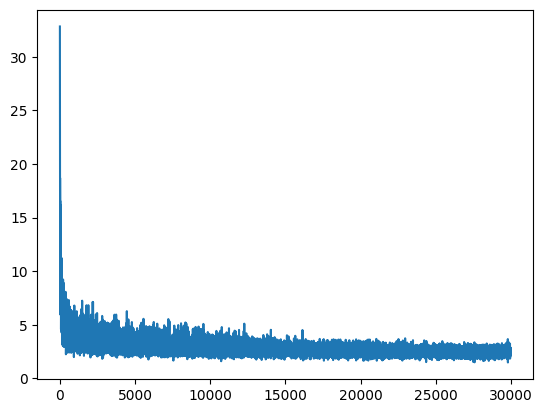

In [175]:
#plot 
plt.plot(stepi, lossi)

In [155]:
# Evaluate all of the dev set

emb = C[X_val] # Embedding lookup
h = torch.tanh(emb.view(-1, 2*block_size) @ W1 + b1)
logits = h @ W2 + b2 # Logits 
loss = F.cross_entropy(logits, Y_val) # Equivalent to the above with Pytorch function
loss

tensor(2.3949, grad_fn=<NllLossBackward0>)

## Visualize the Embeddings

Only works for 2 dimensional embeddings accurately

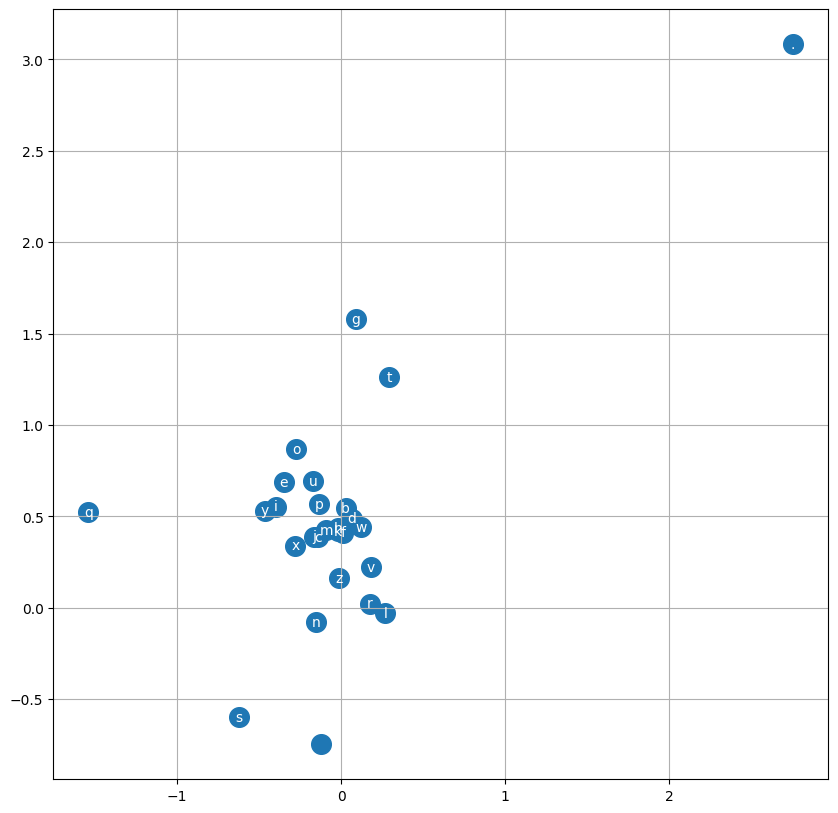

In [172]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200) 
for i in range(C.shape[0]):
    if i in itos:
        plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = 'center', va = 'center', color = 'white', fontsize = 10)
    
plt.grid('minor')
plt.show()

## Plot 3 Dimensional Embeddings Visualization

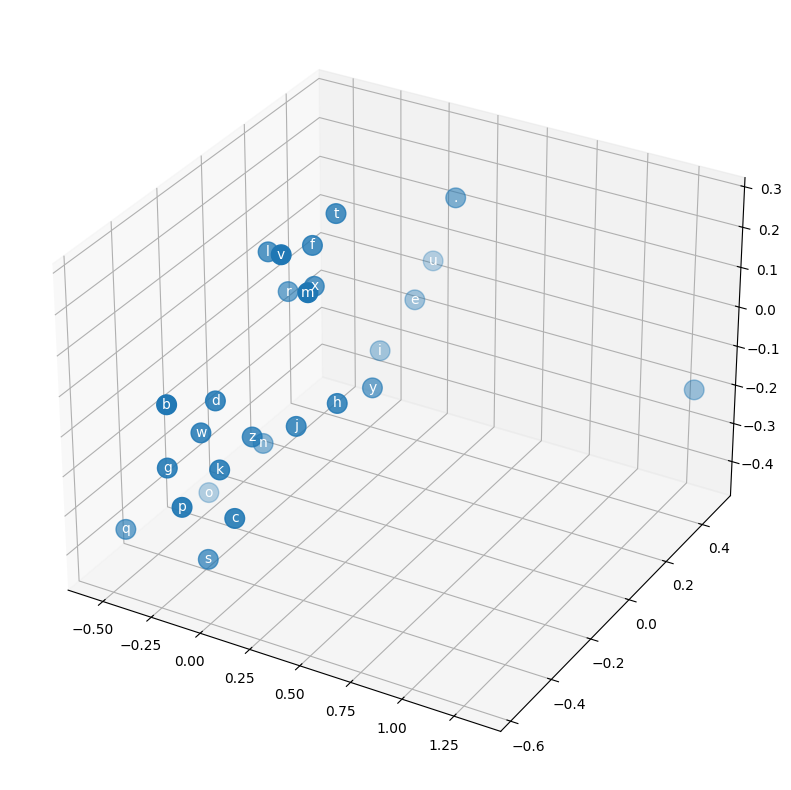

In [176]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(C[:, 0].data, C[:, 1].data, C[:, 2].data, s = 200)

for i in range(C.shape[0]):
    if i in itos:
        ax.text(C[i, 0].item(), C[i, 1].item(), C[i, 2].item(), itos[i], ha = 'center', va = 'center', color = 'white', fontsize = 10)

plt.show()

## Sample from the model 

In [189]:
g  = torch.Generator().manual_seed(42)

for _ in range(10): 
    
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join([itos[i] for i in out]))
        

z.
.
terin.
.
mir.
emyclein.
ni.
ser.
ush.
re.
